# Cross Validation
[J. Nathan Matias](https://natematias.com), April 21, 2020

This notebook is part of [COMM 4940: The Design & Governance of Field Experiments](https://natematias.com/courses/comm4940/)

In today's class, we're discussing the idea of cross-validation, where we confirm the reproducibility of statistical tests by holding back data. The reading for today is here:

* Koul, A., Becchio, C., & Cavallo, A. (2018). [Cross-validation approaches for replicability in psychology](https://www.frontiersin.org/articles/10.3389/fpsyg.2018.01117/full). Frontiers in Psychology, 9, 1117.

Note that for this class, we're going to be thinking about cross-validation differently from prediction tasks (which is how it's often discussed in machine learning). Here, we're focused on meta-analysis, leading into analysis of the Upworthy Research Archive:
* With prediction, you test the error in the overall model
* With meta-analysis, it's fine if the model predicts things badly, so long as we learn the average treatment effect. In fact, adding multiple predictors might lead us to mis-estimate the average treatment effect.

In [19]:
options("scipen"=9, "digits"=4)
library(MASS)
library(ggplot2)
library(rlang)
library(gmodels)  #includes CrossTable
library(corrplot)
library(stringr)
library(plm)      #Fixed effects models

## DOCUMENTATION AT: https://cran.r-project.org/web/packages/DeclareDesign/DeclareDesign.pdf
cbPalette <- c("#999999", "#E69F00", "#56B4E9", "#009E73", "#F0E442", "#0072B2", "#D55E00", "#CC79A7")
options(repr.plot.width=7, repr.plot.height=3.5)

## Set Random Seed:
set.seed(35985)

# Minimizing False Positives with Cross-Validation
Cross-validation can help us minimize false positives in research.

In the following example, we create a dataset with 100 normal distributions that aren't correlated in any way. We then see how many of those correlations survive cross validation

In [2]:
# total sample size
n.size = 1000

## create dataframe
nocorr.df <- data.frame(
    id = seq(1, n.size),
    a = rnorm(n.size),
    b = rnorm(n.size),
    c = rnorm(n.size),
    d = rnorm(n.size),
    e = rnorm(n.size),
    f = rnorm(n.size),
    g = rnorm(n.size),
    h = rnorm(n.size),
    i = rnorm(n.size),
    j = rnorm(n.size)
)

### Creating the Exploratory and Confirmatory (holdout) Datasets
Here, I create two separate, independent datasets from the larger data:
* `nocorr.exploratory.df` is a 30% dataset for exploratory analysis
* `nocorr.confirmatory.df` is a 70% holdout dataset for confirmatory analysis

There's no hard and fast rule for how large the datasets should be, though there are some tradeoffs, as I illustrate at the end of the notebook.

In [3]:
## the proportion of observations
## to include in the exploratory dataset
exp.proportion = 0.3

nocorr.exploratory.df <- nocorr.df[
    sample(1:nrow(nocorr.df), n.size*exp.proportion, replace=FALSE),]

nocorr.confirmatory.df <- subset(nocorr.df, (id %in% nocorr.exploratory.df$id)!=TRUE)

print(paste(nrow(nocorr.exploratory.df), "in the exploratory dataset"))
print(paste(nrow(nocorr.confirmatory.df), "in the confirmatory dataset"))

[1] "300 in the exploratory dataset"
[1] "700 in the confirmatory dataset"


### Developing a Model with the Exploratory Dataset

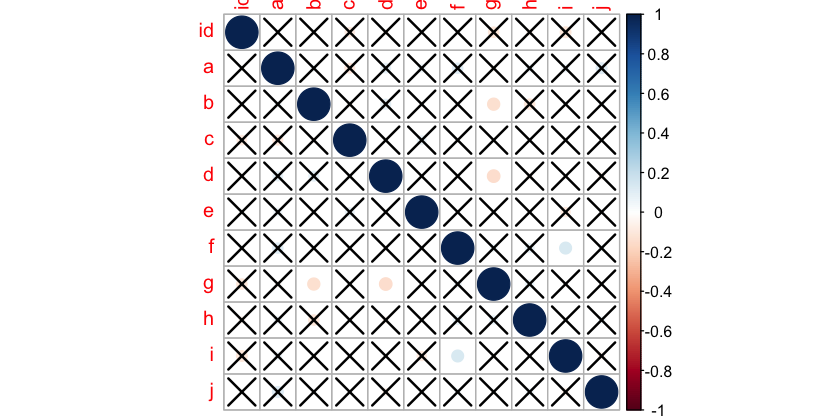

In [4]:
# Let's imagine I was looking for just any correlation in the dataset, with the goal of
# getting some kind of statistically-significant result. Here, we see that both b and d 
# are associated with g

ndt <- cor.mtest(nocorr.exploratory.df, conf.level = .95)
ndc <- cor(nocorr.exploratory.df)
corrplot(ndc, p.mat=ndt$p, sig.level=0.05)

In [5]:
# in this linear regression model, we see that both b and d are associated with g
summary(lm(g ~ b + d, data=nocorr.exploratory.df))


Call:
lm(formula = g ~ b + d, data = nocorr.exploratory.df)

Residuals:
   Min     1Q Median     3Q    Max 
-3.259 -0.649 -0.031  0.596  2.947 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)  
(Intercept)   0.0749     0.0602    1.24    0.214  
b            -0.1373     0.0618   -2.22    0.027 *
d            -0.1453     0.0606   -2.40    0.017 *
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 1.02 on 297 degrees of freedom
Multiple R-squared:  0.0382,	Adjusted R-squared:  0.0317 
F-statistic:  5.9 on 2 and 297 DF,  p-value: 0.00308


### Testing the spurious correlations with the confirmatory dataset

When we test the correlations on a (larger) sample from the population, we fail to reject the null hypothesis that these results are too large to have arisen from chance.

In [6]:
summary(lm(g ~ b + d, data=nocorr.confirmatory.df))


Call:
lm(formula = g ~ b + d, data = nocorr.confirmatory.df)

Residuals:
   Min     1Q Median     3Q    Max 
-3.111 -0.639  0.023  0.650  3.583 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)
(Intercept)   0.0172     0.0370    0.47     0.64
b            -0.0307     0.0375   -0.82     0.41
d            -0.0256     0.0350   -0.73     0.46

Residual standard error: 0.978 on 697 degrees of freedom
Multiple R-squared:  0.00169,	Adjusted R-squared:  -0.00118 
F-statistic: 0.589 on 2 and 697 DF,  p-value: 0.555


# Handling Overfitting with Cross-Validation
Sometimes the best model that fits the data is so specific that it doesn't apply to anything beyond the data. That's what researchers call overfitting (and it's what happened in the above example too).

By giving researchers a chance to test their model on more than one dataset, cross-validation enables researchers to confirm whether their model is overfit.

For this example, we are using the [titanic dataset](http://biostat.mc.vanderbilt.edu/wiki/pub/Main/DataSets/titanic.html), a record of who survived a profound tragedy in 1912 when 1,500 out of 2,208 people [died when the H.M.S. Titanic sunk in the Atlantic](https://en.wikipedia.org/wiki/Passengers_of_the_RMS_Titanic). This dataset includes information about 1309 passengers ([description here](http://biostat.mc.vanderbilt.edu/wiki/pub/Main/DataSets/titanic3info.txt)).

In this case, I want to know if people who paid more money for their ticket (`fare`) had a higher chance of survival, holding all else equal.

In [7]:
## Reset Random Seed:
set.seed(69982)

titanic.df <- read.csv("http://biostat.mc.vanderbilt.edu/wiki/pub/Main/DataSets/titanic3.csv")

titanic.df$is.minor <- as.numeric(titanic.df$age < 18)

t.exploratory.df <- titanic.df[
    sample(1:nrow(titanic.df), nrow(titanic.df)*exp.proportion, replace=FALSE),]

t.confirmatory.df <- subset(titanic.df, (name %in% t.exploratory.df$name)!=TRUE)

print(paste(nrow(t.exploratory.df), "in the exploratory dataset"))
print(paste(nrow(t.confirmatory.df), "in the confirmatory dataset"))
colnames(t.exploratory.df)

[1] "392 in the exploratory dataset"
[1] "917 in the confirmatory dataset"


[1] "pclass"    "survived"  "name"      "sex"       "age"       "sibsp"    
 [7] "parch"     "ticket"    "fare"      "cabin"     "embarked"  "boat"     
[13] "body"      "home.dest" "is.minor"

## First,  Develop an Exploratory Model
Using the exploratory dataset, I can create a model that tests for the correlation I'm curious about. Here, I use the classic exploratory technique of fitting a sequence of models until I find the one that has the highest R2.

The key hypothesis test will be whether `fare` is a statistically-significant predictor of survival, accounting for all other variables.

In [9]:
summary(lm(survived ~ fare, data=t.exploratory.df))


Call:
lm(formula = survived ~ fare, data = t.exploratory.df)

Residuals:
   Min     1Q Median     3Q    Max 
-0.932 -0.317 -0.297  0.611  0.717 

Coefficients:
            Estimate Std. Error t value     Pr(>|t|)    
(Intercept)  0.27364    0.02785    9.82      < 2e-16 ***
fare         0.00297    0.00049    6.06 0.0000000032 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.462 on 389 degrees of freedom
  (1 observation deleted due to missingness)
Multiple R-squared:  0.0863,	Adjusted R-squared:  0.0839 
F-statistic: 36.7 on 1 and 389 DF,  p-value: 0.00000000321


In [10]:
summary(lm(survived ~ fare + pclass, data=t.exploratory.df))


Call:
lm(formula = survived ~ fare + pclass, data = t.exploratory.df)

Residuals:
   Min     1Q Median     3Q    Max 
-0.866 -0.274 -0.237  0.432  0.770 

Coefficients:
             Estimate Std. Error t value       Pr(>|t|)    
(Intercept)  0.668542   0.096237    6.95 0.000000000016 ***
fare         0.001558   0.000582    2.68         0.0078 ** 
pclass      -0.147935   0.034576   -4.28 0.000023720625 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.452 on 388 degrees of freedom
  (1 observation deleted due to missingness)
Multiple R-squared:  0.127,	Adjusted R-squared:  0.123 
F-statistic: 28.3 on 2 and 388 DF,  p-value: 0.00000000000326


In [11]:
summary(lm(survived ~ fare + pclass + sex, data=t.exploratory.df))


Call:
lm(formula = survived ~ fare + pclass + sex, data = t.exploratory.df)

Residuals:
    Min      1Q  Median      3Q     Max 
-0.8715 -0.2576 -0.0916  0.2935  0.9119 

Coefficients:
             Estimate Std. Error t value   Pr(>|t|)    
(Intercept)  1.012286   0.091858   11.02    < 2e-16 ***
fare         0.000744   0.000523    1.42       0.16    
pclass      -0.162171   0.030747   -5.27 0.00000022 ***
sexmale     -0.440026   0.043011  -10.23    < 2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.401 on 387 degrees of freedom
  (1 observation deleted due to missingness)
Multiple R-squared:  0.313,	Adjusted R-squared:  0.308 
F-statistic: 58.8 on 3 and 387 DF,  p-value: <2e-16


In [12]:
summary(lm(survived ~ fare + pclass + sex + age, data=t.exploratory.df))


Call:
lm(formula = survived ~ fare + pclass + sex + age, data = t.exploratory.df)

Residuals:
   Min     1Q Median     3Q    Max 
-0.833 -0.282 -0.102  0.287  0.932 

Coefficients:
             Estimate Std. Error t value  Pr(>|t|)    
(Intercept)  1.185806   0.123359    9.61   < 2e-16 ***
fare         0.000765   0.000549    1.39     0.165    
pclass      -0.181002   0.036471   -4.96 0.0000012 ***
sexmale     -0.434309   0.049732   -8.73   < 2e-16 ***
age         -0.003875   0.001720   -2.25     0.025 *  
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.407 on 303 degrees of freedom
  (84 observations deleted due to missingness)
Multiple R-squared:  0.324,	Adjusted R-squared:  0.315 
F-statistic: 36.3 on 4 and 303 DF,  p-value: <2e-16


#### Here's the final model, which adjusts for passenger class, sex, age, and the number of siblings or parents on the boat.

In [13]:
summary(lm(survived ~ fare + pclass + sex + age + sibsp, data=t.exploratory.df))


Call:
lm(formula = survived ~ fare + pclass + sex + age + sibsp, data = t.exploratory.df)

Residuals:
   Min     1Q Median     3Q    Max 
-0.829 -0.248 -0.108  0.296  0.923 

Coefficients:
             Estimate Std. Error t value  Pr(>|t|)    
(Intercept)  1.231386   0.121696   10.12   < 2e-16 ***
fare         0.001189   0.000551    2.16   0.03188 *  
pclass      -0.163842   0.036102   -4.54 0.0000082 ***
sexmale     -0.448569   0.048955   -9.16   < 2e-16 ***
age         -0.005445   0.001744   -3.12   0.00196 ** 
sibsp       -0.087587   0.024490   -3.58   0.00041 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.399 on 302 degrees of freedom
  (84 observations deleted due to missingness)
Multiple R-squared:  0.351,	Adjusted R-squared:  0.341 
F-statistic: 32.7 on 5 and 302 DF,  p-value: <2e-16


## Next test the hypothesis in the confirmatory dataset

At this point, there are two approaches that you could take when doing hypothesis tests (in contrast with prediction tasks, where we are testing the overall error of the model). 
* Test the hypotheses on the confirmatory dataset alone
* Test the hypotheses on the combined confirmatory + exploratory dataset (the full dataset) (this is the approach we will take here)

Here, when we look for a correlation within the full dataset, we fail to reject the null hypothesis. Accounting for other factors, in this model, there was no relationship between chance of survival and the fare that someone paid.

In [14]:
summary(lm(survived ~ fare + pclass + sex + age + sibsp, data=titanic.df))


Call:
lm(formula = survived ~ fare + pclass + sex + age + sibsp, data = titanic.df)

Residuals:
    Min      1Q  Median      3Q     Max 
-1.1056 -0.2433 -0.0777  0.2308  1.0361 

Coefficients:
             Estimate Std. Error t value      Pr(>|t|)    
(Intercept)  1.297077   0.065258   19.88       < 2e-16 ***
fare         0.000293   0.000270    1.09        0.2778    
pclass      -0.174492   0.018905   -9.23       < 2e-16 ***
sexmale     -0.494774   0.025656  -19.28       < 2e-16 ***
age         -0.005970   0.000954   -6.26 0.00000000057 ***
sibsp       -0.049426   0.013922   -3.55        0.0004 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.389 on 1039 degrees of freedom
  (264 observations deleted due to missingness)
Multiple R-squared:  0.376,	Adjusted R-squared:  0.373 
F-statistic:  125 on 5 and 1039 DF,  p-value: <2e-16


#### So which is the case? Is there a relationship or not? 
In one sample, I fount support for my hypothesis. In the other, I did not. Which is right? My failure to reject the null hypothesis in the confirmatory dataset might be because there's no true relationship in the population, or it might be the luck of the draw. 

Cross-validation can also yield a false negative, where you miss an important relationship that is actually there. Imagine that the exploratory dataset didn't yield a statistically-significant relationship but there was genuinely a relationship in the population of Titanic passengers. And imagine that I hadn't gone on to test that hypothesis because it wasn't statistically-significant in the exploratory dataset. I might have missed an important relationship.

In the case of the Titanic and the Upworthy Research Archive, we can't go back and increase the sample. 

If prediction were our goal, we could calculate root mean square error using the following techniques:

* K-fold cross validation, where we create a series of exploratory sets and then test them against the confirmatory sets
* Leave-one-out cross-validation, where we iterate through all possible samples and test the prediction against the left-out observation

In all of these cases, we would use measures like root mean square error to evaluate the goodness of fit of the model.

# Cross-Validation of a Hypothesis from the Upworthy Research Archive
In this example, I use the upper bound exploratory and confirmatory datasets of experiments naming notable people to:
* develop a hypothesis with the exploratory dataset
* test it with the full dataset

In [15]:
data_dir="../assignments/upworthy-archive-project/"

max.exp.df <- read.csv(paste(data_dir,"upworthy_archive_exploratory_max_effect_size_dataset.csv", sep=""))
max.conf.df <- read.csv(paste(data_dir,"upworthy_archive_confirmatory_max_effect_size_dataset.csv", sep=""))

headlines.df <- read.csv(paste(data_dir,"headlines.csv", sep=""))

### Fit Exploratory Model
Here, I fit a fixed effects model on the hypothesis that including a notable person's name in a headline increases the chance that someone will click on the headline. 

In the upper bound dataset, across 40 tests, including a notable person's name in the headline increases the chance of someone clicking by 3 tenths of a percentage point.

In [16]:
summary(plm(clicked ~ has_treatment,
            index="clickability_test_id",
            model="within",
            data=max.exp.df))

Oneway (individual) effect Within Model

Call:
plm(formula = clicked ~ has_treatment, data = max.exp.df, model = "within", 
    index = "clickability_test_id")

Unbalanced Panel: n = 40, T = 2025-20505, N = 270177

Residuals:
   Min. 1st Qu.  Median 3rd Qu.    Max. 
-0.0708 -0.0183 -0.0122 -0.0074  0.9976 

Coefficients:
              Estimate Std. Error t-value       Pr(>|t|)    
has_treatment 0.003326   0.000491    6.77 0.000000000013 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Total Sum of Squares:    4400
Residual Sum of Squares: 4400
R-Squared:      0.00017
Adj. R-Squared: 0.0000215
F-statistic: 45.8122 on 1 and 270136 DF, p-value: 0.000000000013

### What does exploration look like for the Upworthy Research Archive?

In this case, how might we adjust our model based on this exploratory data analysis, since we only have one predictor?
* Maybe headline selection isn't precise enough:
    * If we don't have enough names in our list, maybe we're inadvertently comparing two headlines that both have notable names
    * Maybe the comparison headlines (without notable names) are very different in some other way that skews the results, for example have a different length or more positive/negative phrasing
* Maybe there's a `mediating` factor, such as how famous the person is. Maybe we need to add another variable for how popular they were at the time

These are all areas where further adjustment and exploration could improve the model or could lead to overfitting.

### Testing the Confirmatory Hypothesis
In the next step, it's important to be very precise about what we are confirming. Options include:
* a hypothesis about the existence of an effect (the hypothesis that has_treatment is statistically-significant)
* a hypothesis about the sign of the effect (the hypothesis that has_treatment is greater than zero and statistically-significant)
* a prediction about magnitude of the estimate (the hypothesis that has_treatment is at least X and statistically-significant)

In this case, I'm choosing the following hypothesis test (which I did actually decide on before testing against the confirmatory dataset):

**Hypothesis:** including a notable person's name in a headline as defined in `selecting_upworthy_archive_packages.py`, has an upper bound effect that is positive and statistically significant.

Here, since we're doing meta-analysis and want to include all possible information, I'm *combining* the exploratory and confirmatory datasets into one final model.

**Result:** the hypothesis is confirmed. On average across the upper-bound dataset of 297 A/B tests (and 2.1 million viewers), including a notable person's name in a headline increased the chance that someone clicked by 4 tenths of a percentage point, an effect that is positive and statistically-significant.

In [17]:
max.df <- rbind(max.exp.df, max.conf.df)
summary(plm(clicked ~ has_treatment,
            index="clickability_test_id",
            model="within",
            data=max.df))

Oneway (individual) effect Within Model

Call:
plm(formula = clicked ~ has_treatment, data = max.df, model = "within", 
    index = "clickability_test_id")

Unbalanced Panel: n = 297, T = 306-21598, N = 2136155

Residuals:
    Min.  1st Qu.   Median  3rd Qu.     Max. 
-0.10750 -0.01822 -0.01070 -0.00637  1.00076 

Coefficients:
              Estimate Std. Error t-value Pr(>|t|)    
has_treatment 0.004110   0.000163    25.2   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Total Sum of Squares:    30200
Residual Sum of Squares: 30200
R-Squared:      0.000298
Adj. R-Squared: 0.000159
F-statistic: 637.331 on 1 and 2135857 DF, p-value: <2e-16

### Other ways to cross-validate
I used this technique because it is relatively straightforward and involves just expanding the available data. This is what I will be doing for the final.

For meta-analysis, I'll be honest that I'm not (yet) sure how to conduct the other techniques, since the exploratory process is focused on defining variables and selecting the tests that go into the dataset.

I'm not currently aware of anyone else who has used cross-validation to test hypotheses from a large dataset of experiments (though I bet this has been done in medicine).

For correlational analyses like the Titanic example, k-fold and leave-one-subject-out are simpler because you can compare the Root Mean Square Error of a model with the key predictor (`fare`) to one without the predictor. If your preferre model is a better fit, then you uphold the finding from that model.

# Software Environment
This example was generated using the following R configurations and libraries.

In [18]:
sessionInfo()

R version 3.5.1 (2018-07-02)
Platform: x86_64-apple-darwin15.6.0 (64-bit)
Running under: macOS  10.14.6

Matrix products: default
BLAS: /Library/Frameworks/R.framework/Versions/3.5/Resources/lib/libRblas.0.dylib
LAPACK: /Library/Frameworks/R.framework/Versions/3.5/Resources/lib/libRlapack.dylib

locale:
[1] en_US.UTF-8/en_US.UTF-8/en_US.UTF-8/C/en_US.UTF-8/en_US.UTF-8

attached base packages:
[1] stats     graphics  grDevices utils     datasets  methods   base     

other attached packages:
[1] plm_2.2-3      stringr_1.3.1  corrplot_0.84  gmodels_2.18.1 rlang_0.3.0.1 
[6] ggplot2_3.1.0  MASS_7.3-51.1 

loaded via a namespace (and not attached):
 [1] Rcpp_1.0.0       pillar_1.3.1     compiler_3.5.1   plyr_1.8.4      
 [5] miscTools_0.6-26 base64enc_0.1-3  tools_3.5.1      digest_0.6.18   
 [9] uuid_0.1-2       nlme_3.1-137     lattice_0.20-38  jsonlite_1.6    
[13] evaluate_0.13    tibble_2.0.0     gtable_0.2.0     pkgconfig_2.0.2 
[17] bibtex_0.4.2     IRdisplay_0.7.0  maxLik_1.3-8    

# You are Free to Copy & Reuse this Code¶ 
Copyright 2019 J. Nathan Matias

Permission is hereby granted, free of charge, to any person obtaining a copy of this software and associated documentation files (the "Software"), to deal in the Software without restriction, including without limitation the rights to use, copy, modify, merge, publish, distribute, sublicense, and/or sell copies of the Software, and to permit persons to whom the Software is furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in all copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY, FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE SOFTWARE.